In [1]:

import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.ensemble import BaggingRegressor
import math

#+++++++++++++++++++++++++++++++++++++++++++++++++ PREPROCESSING ++++++++++++++++++++++++++++++++++++++++++++++

ice_velocity = pd.read_csv('../data/ice_velocity.csv')

#removing any rows with ice_velocity -1
ice_velocity = ice_velocity[ice_velocity['ice_velocity']!=-1]

#method to normalise the data -> scale each column between 0 and 1 
def scale (df):
    """uses the formula scaled val = (val-column minimum)/(column maximum - column minimum)"""
    scaled_df = df.copy()
    # for column in df.columns[:-1]  -> use this line instead for not having a scaled target 
    for column in scaled_df.columns:
        min_value = scaled_df[column].min()
        max_value = scaled_df[column].max()
        scaled_df[column] = (scaled_df[column] - min_value) / (max_value - min_value)
            
    return scaled_df

def unscale_rmse(scaled_rmse, target_name, original_df):
    target_min = original_df[target_name].min()
    target_max = original_df[target_name].max()

    return scaled_rmse * (target_max - target_min)


In [40]:
len(ice_velocity.index)

929

In [53]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import numpy as np
import math


def doRandomForestWithTuning(preprocessed_df, seed, n_runs, target_name, original_df):
    train_scores = []
    test_scores = []
    train_RMSEs = []
    test_RMSEs = []
    importances = []
    best_params = []
    
    X = preprocessed_df.iloc[:, :-1]
    y = preprocessed_df.iloc[:, -1]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)

    for i in range(n_runs):
        randomState = i * seed

        # Define the model -> the random state means different trees will be created each time
                        #  -> but in a controlled way so it is reproducible 
        rf = RandomForestRegressor(random_state=randomState)

        # Set up the grid of parameters to search
        param_grid = {
            'n_estimators': [100, 200, 300],
            'max_depth': [None, 10, 20],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'max_features': [1,2,3], 
            'max_leaf_nodes':[300, 600, 931]
            # Add other parameters here
        }

        # Set up the grid search
        grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=1)

        # Fit the grid search to the data
        grid_search.fit(X_train, y_train)

        # Store best parameters
        #best_params.append(grid_search.best_params_)
        best_params.append(grid_search.cv_results_['params'][grid_search.best_index_])

    print("Best Parameters per Run:", best_params)

    return best_params, param_grid

In [54]:
seed = 101
scaled_df = scale(ice_velocity)
n_runs =30
best_params, param_grid = doRandomForestWithTuning(scaled_df, seed, n_runs, "ice_velocity", ice_velocity)


Fitting 3 folds for each of 729 candidates, totalling 2187 fits
Fitting 3 folds for each of 729 candidates, totalling 2187 fits
Fitting 3 folds for each of 729 candidates, totalling 2187 fits
Fitting 3 folds for each of 729 candidates, totalling 2187 fits
Fitting 3 folds for each of 729 candidates, totalling 2187 fits
Fitting 3 folds for each of 729 candidates, totalling 2187 fits
Fitting 3 folds for each of 729 candidates, totalling 2187 fits
Fitting 3 folds for each of 729 candidates, totalling 2187 fits
Fitting 3 folds for each of 729 candidates, totalling 2187 fits
Fitting 3 folds for each of 729 candidates, totalling 2187 fits
Fitting 3 folds for each of 729 candidates, totalling 2187 fits
Fitting 3 folds for each of 729 candidates, totalling 2187 fits
Fitting 3 folds for each of 729 candidates, totalling 2187 fits
Fitting 3 folds for each of 729 candidates, totalling 2187 fits
Fitting 3 folds for each of 729 candidates, totalling 2187 fits
Fitting 3 folds for each of 729 candidat

param counts
n_estimators
100     9
200     9
300    12
Name: count, dtype: int64


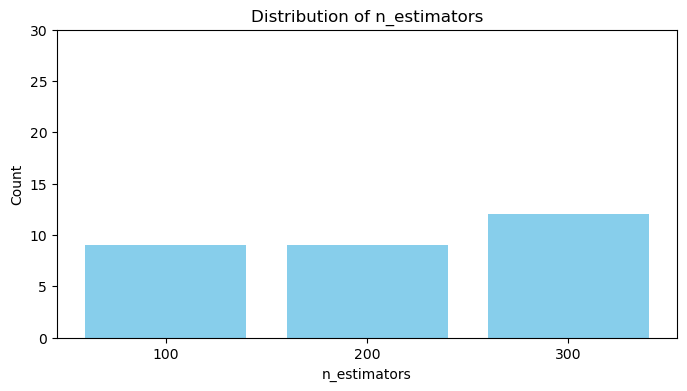

param counts
max_depth
None     9
10       5
20      16
Name: count, dtype: int64


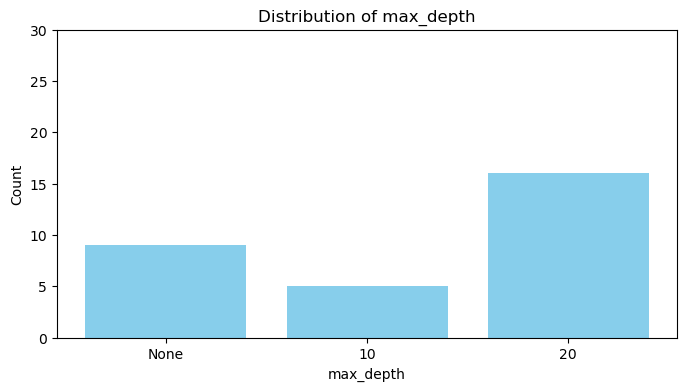

param counts
min_samples_split
2     27
5      3
10     0
Name: count, dtype: int64


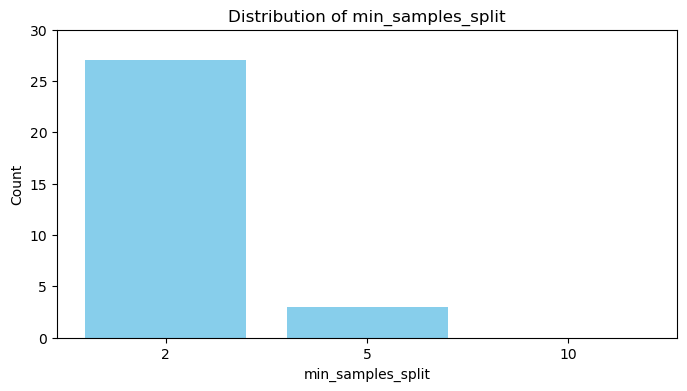

param counts
min_samples_leaf
1    27
2     3
4     0
Name: count, dtype: int64


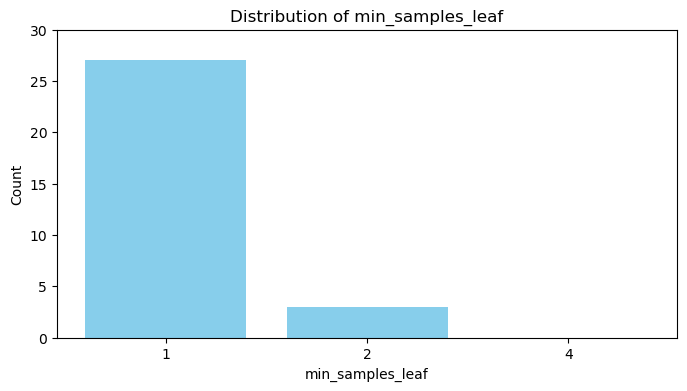

param counts
max_features
1    27
2     3
3     0
Name: count, dtype: int64


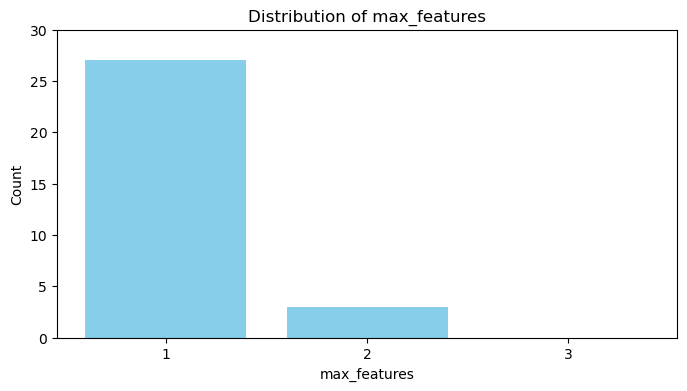

param counts
max_leaf_nodes
300    30
600     0
931     0
Name: count, dtype: int64


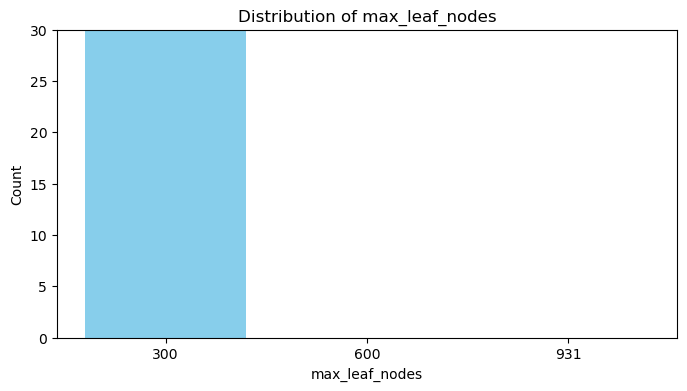

In [55]:
import matplotlib.pyplot as plt

def visualize_parameter_distribution_no_grid(param_dict, param_grid, n_runs):
    # Convert 'None' to string 'None' for 'max_depth'
    for d in param_dict:
        if 'max_depth' in d and d['max_depth'] is None:
            d['max_depth'] = 'None'
    
    # Convert the dictionary to a DataFrame for easier manipulation
    df = pd.DataFrame(param_dict)

    # Loop through each parameter in the grid and create separate bar charts
    for param, values in param_grid.items():
        
        if param == "max_depth":
            values = ['None' if v is None else v for v in values]
            
        
        # Count the occurrences of each parameter value in the dictionary
        param_counts = df[param].value_counts().reindex(values, fill_value=0)
        print("param counts")
        print(param_counts)
        # Plot the bar chart for the parameter
        plt.figure(figsize=(8, 4))
        plt.bar(param_counts.index.astype(str), param_counts.values, color='skyblue')
        plt.title(f'Distribution of {param}')
        plt.xlabel(param)
        plt.ylabel('Count')
        plt.ylim(0, n_runs)  # Set y-axis limit to n_runs
        plt.show()

# Call the function with the 'n_runs' parameter
n_runs=30
visualize_parameter_distribution_no_grid(best_params, param_grid, n_runs)

In [113]:
#+++++++++++++++++++++++++++++++++++++++++++++ RF REGRESSION +++++++++++++++++++++++++++++++++++++++++++
def doRandomForest(preprocessed_df, seed, n_runs, target_name, original_df):
    train_scores = []
    test_scores = []
    train_RMSEs = []
    test_RMSEs = []
    importances = []

    for i in range(n_runs):
        randomState = i * seed
        X = preprocessed_df.iloc[:, :-1]
        y = preprocessed_df.iloc[:, -1]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=randomState)

        model = RandomForestRegressor(random_state=randomState, n_estimators = 300, max_leaf_nodes = 10, 
                                      min_samples_split=25, min_samples_leaf = 5, max_features = 1, 
                                      max_depth=10)
        model.fit(X_train, y_train)


        # Store metrics for training set
        train_scores.append(model.score(X_train, y_train))
        y_train_predicted = model.predict(X_train)
        train_scaled_rmse = math.sqrt(mean_squared_error(y_train, y_train_predicted))
        train_rmse = unscale_rmse(train_scaled_rmse, target_name, original_df)
        train_RMSEs.append(train_rmse)

        # Store metrics for test set
        test_scores.append(model.score(X_test, y_test))
        importances.append(model.feature_importances_)
        y_test_predicted = model.predict(X_test)
        test_scaled_rmse = math.sqrt(mean_squared_error(y_test, y_test_predicted))
        test_rmse = unscale_rmse(test_scaled_rmse, target_name, original_df)
        test_RMSEs.append(test_rmse)

    # Calculate the average and standard deviation for each metric
    avg_train_score, std_train_score = np.mean(train_scores), np.std(train_scores)
    avg_test_score, std_test_score = np.mean(test_scores), np.std(test_scores)
    avg_train_rmse, std_train_rmse = np.mean(train_RMSEs), np.std(train_RMSEs)
    avg_test_rmse, std_test_rmse = np.mean(test_RMSEs), np.std(test_RMSEs)
    avg_importances, std_importances = np.mean(importances, axis=0), np.std(importances, axis=0)

    # Output the results
    print(f"Training Average Score: {avg_train_score:.4f}, Std Dev: {std_train_score:.4f}")
    print(f"Training Average RMSE: {avg_train_rmse:.2f}, Std Dev: {std_train_rmse:.2f}")
    print("\n")
    print(f"Test Average Score: {avg_test_score:.4f}, Std Dev: {std_test_score:.4f}")
    print(f"Test Average RMSE: {avg_test_rmse:.2f}, Std Dev: {std_test_rmse:.2f}")
    print("\n")
    print("Average Importances:", avg_importances)
    print("Importances Std Dev:", std_importances)


    return avg_importances, std_importances

In [114]:
seed = 101
scaled_df = scale(ice_velocity)
n_runs =30
best_params, param_grid = doRandomForest(scaled_df, seed, n_runs, "ice_velocity", ice_velocity)


Training Average Score: 0.3466, Std Dev: 0.0326
Training Average RMSE: 246.06, Std Dev: 19.36


Test Average Score: 0.1744, Std Dev: 0.0486
Test Average RMSE: 273.24, Std Dev: 49.04


Average Importances: [0.14803421 0.09809015 0.27052132 0.31284806 0.17050626]
Importances Std Dev: [0.01342159 0.01523133 0.02226166 0.02494539 0.02326722]


In [103]:
#+++++++++++++++++++++++++++++++++++++++++++++ RF REGRESSION +++++++++++++++++++++++++++++++++++++++++++
def doRandomForestSetMaxLN(preprocessed_df, seed, n_runs, target_name, original_df, max_leaf_nodes):
    train_scores = []
    test_scores = []
    train_RMSEs = []
    test_RMSEs = []
    importances = []

    for i in range(n_runs):
        randomState = i * seed
        X = preprocessed_df.iloc[:, :-1]
        y = preprocessed_df.iloc[:, -1]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=randomState)

        model = RandomForestRegressor(random_state=randomState, n_estimators = 300, max_depth = 20, 
                                      min_samples_split=2, min_samples_leaf = 1, max_features = 1, 
                                     max_leaf_nodes = max_leaf_nodes)
        model.fit(X_train, y_train)

        #, max_features = 2
        # Store metrics for training set
        train_scores.append(model.score(X_train, y_train))
        y_train_predicted = model.predict(X_train)
        train_scaled_rmse = math.sqrt(mean_squared_error(y_train, y_train_predicted))
        train_rmse = unscale_rmse(train_scaled_rmse, target_name, original_df)
        train_RMSEs.append(train_rmse)

        # Store metrics for test set
        test_scores.append(model.score(X_test, y_test))
        importances.append(model.feature_importances_)
        y_test_predicted = model.predict(X_test)
        test_scaled_rmse = math.sqrt(mean_squared_error(y_test, y_test_predicted))
        test_rmse = unscale_rmse(test_scaled_rmse, target_name, original_df)
        test_RMSEs.append(test_rmse)

    # Calculate the average and standard deviation for each metric
    avg_train_score, std_train_score = np.mean(train_scores), np.std(train_scores)
    avg_test_score, std_test_score = np.mean(test_scores), np.std(test_scores)
    avg_train_rmse, std_train_rmse = np.mean(train_RMSEs), np.std(train_RMSEs)
    avg_test_rmse, std_test_rmse = np.mean(test_RMSEs), np.std(test_RMSEs)
    avg_importances, std_importances = np.mean(importances, axis=0), np.std(importances, axis=0)

    # Output the results
    print(f"Training Average Score: {avg_train_score:.4f}, Std Dev: {std_train_score:.4f}")
    print(f"Training Average RMSE: {avg_train_rmse:.2f}, Std Dev: {std_train_rmse:.2f}")
    print("\n")
    print(f"Test Average Score: {avg_test_score:.4f}, Std Dev: {std_test_score:.4f}")
    print(f"Test Average RMSE: {avg_test_rmse:.2f}, Std Dev: {std_test_rmse:.2f}")
    print("\n")
    print("Average Importances:", avg_importances)
    print("Importances Std Dev:", std_importances)
    print(f"\n\n Train-Test (Difference): {avg_train_score - avg_test_score :.4f}")


    return avg_train_score, avg_test_score

Training Average Score: 0.1640, Std Dev: 0.0219
Training Average RMSE: 278.52, Std Dev: 22.57


Test Average Score: 0.0856, Std Dev: 0.0353
Test Average RMSE: 287.97, Std Dev: 52.82


Average Importances: [0.19333333 0.202      0.20055556 0.203      0.20111111]
Importances Std Dev: [0.02155097 0.02495329 0.02336638 0.02011725 0.02327506]


 Train-Test (Difference): 0.0784
Training Average Score: 0.2893, Std Dev: 0.0372
Training Average RMSE: 256.64, Std Dev: 20.47


Test Average Score: 0.1123, Std Dev: 0.0551
Test Average RMSE: 283.34, Std Dev: 50.63


Average Importances: [0.16477896 0.11044032 0.26192619 0.28488817 0.17796637]
Importances Std Dev: [0.02411215 0.02756244 0.02311126 0.02392849 0.021678  ]


 Train-Test (Difference): 0.1770
Training Average Score: 0.4315, Std Dev: 0.0372
Training Average RMSE: 229.48, Std Dev: 18.86


Test Average Score: 0.1188, Std Dev: 0.0720
Test Average RMSE: 281.88, Std Dev: 49.19


Average Importances: [0.15060158 0.11968512 0.26320043 0.29067291 

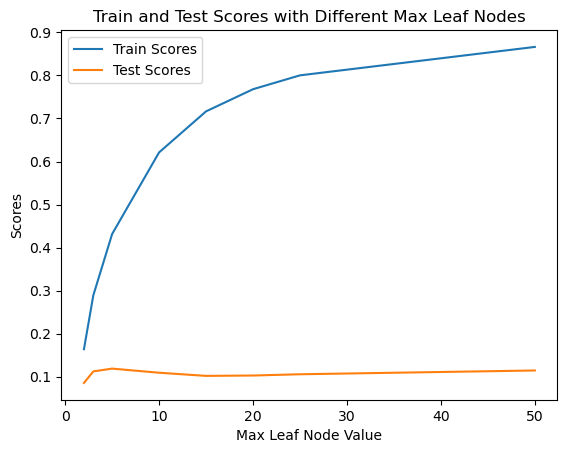

In [105]:
def validate_max_leaf_node(list_of_values):
    test_scores = []
    train_scores = []
    for i in list_of_values:
        train_score, test_score = doRandomForestSetMaxLN(scaled_df, seed, n_runs, "ice_velocity", ice_velocity, i)
        train_scores.append(train_score)
        test_scores.append(test_score)
    
    print("train scores", train_scores)
    print("test scores", test_scores)
    
    # plot the scores
    plt.plot(list_of_values, train_scores, label='Train Scores')
    plt.plot(list_of_values, test_scores, label='Test Scores')
    
    # add labels and title
    plt.xlabel('Max Leaf Node Value')
    plt.ylabel('Scores')
    plt.title('Train and Test Scores with Different Max Leaf Nodes')
    
    # display the legend
    plt.legend()
    
    # show the plot
    plt.show()

validate_max_leaf_node([2, 3, 5, 10, 15, 20, 25, 50])

In [69]:
#+++++++++++++++++++++++++++++++++++++++++++++ RF REGRESSION +++++++++++++++++++++++++++++++++++++++++++
def doRandomForestSetMinSamplesLeaf(preprocessed_df, seed, n_runs, target_name, original_df, min_samples_leaf):
    train_scores = []
    test_scores = []
    train_RMSEs = []
    test_RMSEs = []
    importances = []

    for i in range(n_runs):
        randomState = i * seed
        X = preprocessed_df.iloc[:, :-1]
        y = preprocessed_df.iloc[:, -1]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=randomState)

        model = RandomForestRegressor(random_state=randomState, n_estimators = 300, max_depth = 20, 
                                      min_samples_split=2, min_samples_leaf = min_samples_leaf, max_features = 1, 
                                     max_leaf_nodes = 300)
        model.fit(X_train, y_train)

        # Store metrics for training set
        train_scores.append(model.score(X_train, y_train))
        y_train_predicted = model.predict(X_train)
        train_scaled_rmse = math.sqrt(mean_squared_error(y_train, y_train_predicted))
        train_rmse = unscale_rmse(train_scaled_rmse, target_name, original_df)
        train_RMSEs.append(train_rmse)

        # Store metrics for test set
        test_scores.append(model.score(X_test, y_test))
        importances.append(model.feature_importances_)
        y_test_predicted = model.predict(X_test)
        test_scaled_rmse = math.sqrt(mean_squared_error(y_test, y_test_predicted))
        test_rmse = unscale_rmse(test_scaled_rmse, target_name, original_df)
        test_RMSEs.append(test_rmse)

    # Calculate the average and standard deviation for each metric
    avg_train_score, std_train_score = np.mean(train_scores), np.std(train_scores)
    avg_test_score, std_test_score = np.mean(test_scores), np.std(test_scores)
    avg_train_rmse, std_train_rmse = np.mean(train_RMSEs), np.std(train_RMSEs)
    avg_test_rmse, std_test_rmse = np.mean(test_RMSEs), np.std(test_RMSEs)
    avg_importances, std_importances = np.mean(importances, axis=0), np.std(importances, axis=0)

    # Output the results
    print(f"Training Average Score: {avg_train_score:.4f}, Std Dev: {std_train_score:.4f}")
    print(f"Training Average RMSE: {avg_train_rmse:.2f}, Std Dev: {std_train_rmse:.2f}")
    print("\n")
    print(f"Test Average Score: {avg_test_score:.4f}, Std Dev: {std_test_score:.4f}")
    print(f"Test Average RMSE: {avg_test_rmse:.2f}, Std Dev: {std_test_rmse:.2f}")
    print("\n")
    print("Average Importances:", avg_importances)
    print("Importances Std Dev:", std_importances)
    print(f"\n\n Train-Test (Difference): {avg_train_score - avg_test_score :.4f}")


    return avg_train_score, avg_test_score

Training Average Score: 0.8840, Std Dev: 0.0099
Training Average RMSE: 103.55, Std Dev: 7.98


Test Average Score: 0.1192, Std Dev: 0.1314
Test Average RMSE: 279.97, Std Dev: 44.85


Average Importances: [0.15133253 0.14669556 0.24797563 0.26289151 0.19110478]
Importances Std Dev: [0.00935944 0.01314621 0.01556248 0.01443001 0.01368826]


 Train-Test (Difference): 0.7648
Training Average Score: 0.6584, Std Dev: 0.0290
Training Average RMSE: 177.69, Std Dev: 13.83


Test Average Score: 0.1612, Std Dev: 0.0894
Test Average RMSE: 274.31, Std Dev: 46.01


Average Importances: [0.15370896 0.13693822 0.24877298 0.27814559 0.18243425]
Importances Std Dev: [0.00928593 0.01471833 0.0177659  0.01732937 0.01677719]


 Train-Test (Difference): 0.4972
Training Average Score: 0.5456, Std Dev: 0.0314
Training Average RMSE: 205.12, Std Dev: 16.40


Test Average Score: 0.1755, Std Dev: 0.0728
Test Average RMSE: 272.45, Std Dev: 47.07


Average Importances: [0.1533969  0.12751905 0.25228585 0.28761409 0

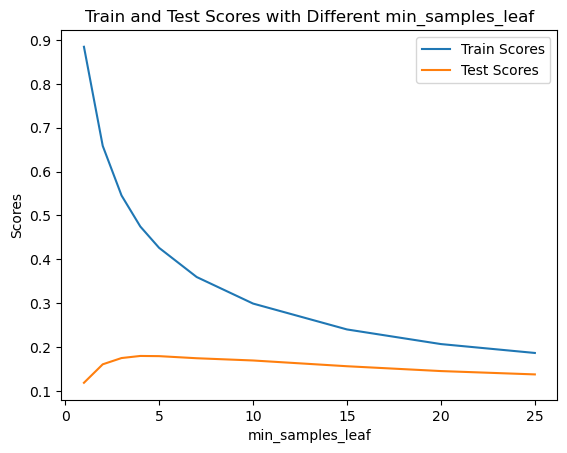

In [72]:
def validate_min_samples_leaf(list_of_values):
    test_scores = []
    train_scores = []
    for i in list_of_values:
        train_score, test_score = doRandomForestSetMinSamplesLeaf(scaled_df, seed, n_runs, "ice_velocity", ice_velocity, i)
        train_scores.append(train_score)
        test_scores.append(test_score)
    
    print("train scores", train_scores)
    print("test scores", test_scores)
    
    # plot the scores
    plt.plot(list_of_values, train_scores, label='Train Scores')
    plt.plot(list_of_values, test_scores, label='Test Scores')
    
    # add labels and title
    plt.xlabel('min_samples_leaf')
    plt.ylabel('Scores')
    plt.title('Train and Test Scores with Different min_samples_leaf')
    
    # display the legend
    plt.legend()
    
    # show the plot
    plt.show()

validate_min_samples_leaf([1, 2, 3, 4, 5, 7, 10, 15, 20, 25])

In [73]:
#+++++++++++++++++++++++++++++++++++++++++++++ RF REGRESSION +++++++++++++++++++++++++++++++++++++++++++
def doRandomForestSetMinSamplesSplit(preprocessed_df, seed, n_runs, target_name, original_df, min_samples_split):
    train_scores = []
    test_scores = []

    for i in range(n_runs):
        randomState = i * seed
        X = preprocessed_df.iloc[:, :-1]
        y = preprocessed_df.iloc[:, -1]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=randomState)

        model = RandomForestRegressor(random_state=randomState, n_estimators = 300, max_depth = 20, 
                                      min_samples_split=min_samples_split, min_samples_leaf = 1, max_features = 1, 
                                     max_leaf_nodes = 300)
        model.fit(X_train, y_train)

        # Store metrics for training set
        train_scores.append(model.score(X_train, y_train))

        # Store metrics for test set
        test_scores.append(model.score(X_test, y_test))


    # Calculate the average and standard deviation for each metric
    avg_train_score, std_train_score = np.mean(train_scores), np.std(train_scores)
    avg_test_score, std_test_score = np.mean(test_scores), np.std(test_scores)

    # Output the results
    print(f"Training Average Score: {avg_train_score:.4f}, Std Dev: {std_train_score:.4f}")
    print("\n")
    print(f"Test Average Score: {avg_test_score:.4f}, Std Dev: {std_test_score:.4f}")
    print("\n")
    print(f"\n\n Train-Test (Difference): {avg_train_score - avg_test_score :.4f}")
    print('\n')

    return avg_train_score, avg_test_score

Training Average Score: 0.8840, Std Dev: 0.0099


Test Average Score: 0.1192, Std Dev: 0.1314




 Train-Test (Difference): 0.7648


Training Average Score: 0.8210, Std Dev: 0.0161


Test Average Score: 0.1276, Std Dev: 0.1314




 Train-Test (Difference): 0.6934


Training Average Score: 0.7663, Std Dev: 0.0212


Test Average Score: 0.1324, Std Dev: 0.1240




 Train-Test (Difference): 0.6339


Training Average Score: 0.7229, Std Dev: 0.0247


Test Average Score: 0.1384, Std Dev: 0.1213




 Train-Test (Difference): 0.5845


Training Average Score: 0.6577, Std Dev: 0.0267


Test Average Score: 0.1448, Std Dev: 0.1138




 Train-Test (Difference): 0.5129


Training Average Score: 0.5936, Std Dev: 0.0322


Test Average Score: 0.1462, Std Dev: 0.1088




 Train-Test (Difference): 0.4474


Training Average Score: 0.5648, Std Dev: 0.0365


Test Average Score: 0.1476, Std Dev: 0.1066




 Train-Test (Difference): 0.4171


Training Average Score: 0.5315, Std Dev: 0.0414


Test Average Score:

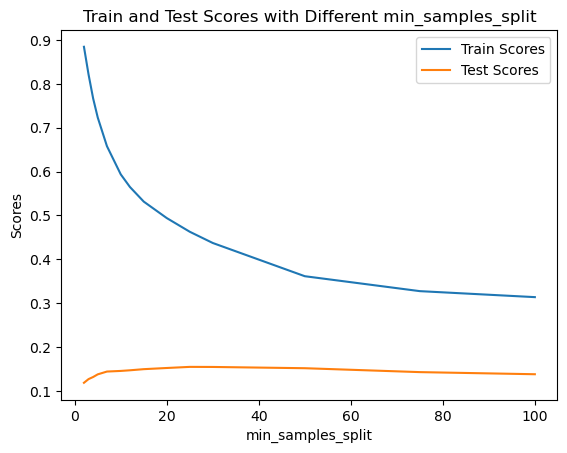

In [77]:
def validate_min_samples_split(list_of_values):
    test_scores = []
    train_scores = []
    for i in list_of_values:
        train_score, test_score = doRandomForestSetMinSamplesSplit(scaled_df, seed, n_runs, "ice_velocity", ice_velocity, i)
        train_scores.append(train_score)
        test_scores.append(test_score)
    
    print("train scores", train_scores)
    print("test scores", test_scores)
    
    # plot the scores
    plt.plot(list_of_values, train_scores, label='Train Scores')
    plt.plot(list_of_values, test_scores, label='Test Scores')
    
    # add labels and title
    plt.xlabel('min_samples_split')
    plt.ylabel('Scores')
    plt.title('Train and Test Scores with Different min_samples_split')
    
    # display the legend
    plt.legend()
    
    # show the plot
    plt.show()

validate_min_samples_split([2, 3, 4, 5, 7, 10, 12, 15, 20, 25, 30, 50, 75, 100])

In [78]:
#+++++++++++++++++++++++++++++++++++++++++++++ RF REGRESSION +++++++++++++++++++++++++++++++++++++++++++
def doRandomForestSetMaxFeatures(preprocessed_df, seed, n_runs, target_name, original_df, max_features):
    train_scores = []
    test_scores = []

    for i in range(n_runs):
        randomState = i * seed
        X = preprocessed_df.iloc[:, :-1]
        y = preprocessed_df.iloc[:, -1]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=randomState)

        model = RandomForestRegressor(random_state=randomState, n_estimators = 300, max_depth = 20, 
                                      min_samples_split=2, min_samples_leaf = 1, max_features = max_features, 
                                     max_leaf_nodes = 300)
        model.fit(X_train, y_train)

        # Store metrics for training set
        train_scores.append(model.score(X_train, y_train))

        # Store metrics for test set
        test_scores.append(model.score(X_test, y_test))


    # Calculate the average and standard deviation for each metric
    avg_train_score, std_train_score = np.mean(train_scores), np.std(train_scores)
    avg_test_score, std_test_score = np.mean(test_scores), np.std(test_scores)

    # Output the results
    print(f"Training Average Score: {avg_train_score:.4f}, Std Dev: {std_train_score:.4f}")
    print("\n")
    print(f"Test Average Score: {avg_test_score:.4f}, Std Dev: {std_test_score:.4f}")
    print("\n")
    print(f"\n\n Train-Test (Difference): {avg_train_score - avg_test_score :.4f}")
    print('\n')

    return avg_train_score, avg_test_score

Training Average Score: 0.8840, Std Dev: 0.0099


Test Average Score: 0.1192, Std Dev: 0.1314




 Train-Test (Difference): 0.7648


Training Average Score: 0.8802, Std Dev: 0.0104


Test Average Score: 0.0632, Std Dev: 0.1767




 Train-Test (Difference): 0.8171


Training Average Score: 0.8778, Std Dev: 0.0101


Test Average Score: 0.0471, Std Dev: 0.1882




 Train-Test (Difference): 0.8307


train scores [0.8839792137468601, 0.8802206264659603, 0.8778488166301995]
test scores [0.11920116979381427, 0.06315219800218053, 0.04711039799993067]


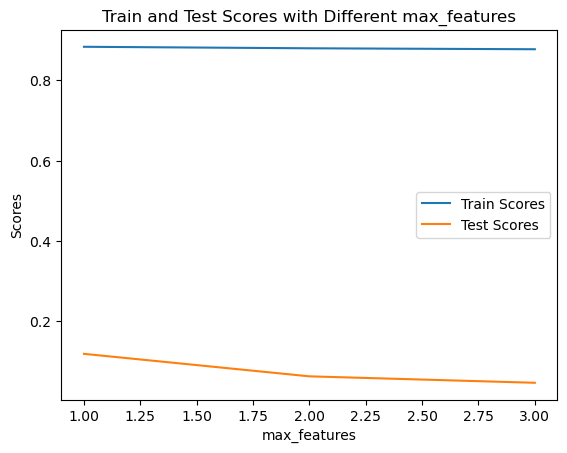

In [79]:
def validate_max_features(list_of_values):
    test_scores = []
    train_scores = []
    for i in list_of_values:
        train_score, test_score = doRandomForestSetMaxFeatures(scaled_df, seed, n_runs, "ice_velocity", ice_velocity, i)
        train_scores.append(train_score)
        test_scores.append(test_score)
    
    print("train scores", train_scores)
    print("test scores", test_scores)
    
    # plot the scores
    plt.plot(list_of_values, train_scores, label='Train Scores')
    plt.plot(list_of_values, test_scores, label='Test Scores')
    
    # add labels and title
    plt.xlabel('max_features')
    plt.ylabel('Scores')
    plt.title('Train and Test Scores with Different max_features')
    
    # display the legend
    plt.legend()
    
    # show the plot
    plt.show()

validate_max_features([1,2,3])

In [89]:
#+++++++++++++++++++++++++++++++++++++++++++++ RF REGRESSION +++++++++++++++++++++++++++++++++++++++++++
def doRandomForestSetMaxDepth(preprocessed_df, seed, n_runs, target_name, original_df, max_depth):
    train_scores = []
    test_scores = []

    for i in range(n_runs):
        randomState = i * seed
        X = preprocessed_df.iloc[:, :-1]
        y = preprocessed_df.iloc[:, -1]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=randomState)

        model = RandomForestRegressor(random_state=randomState, n_estimators = 300, max_depth = max_depth, 
                                      min_samples_split=2, min_samples_leaf = 1, max_features = 1, 
                                     max_leaf_nodes = 300)
        model.fit(X_train, y_train)

        # Store metrics for training set
        train_scores.append(model.score(X_train, y_train))

        # Store metrics for test set
        test_scores.append(model.score(X_test, y_test))


    # Calculate the average and standard deviation for each metric
    avg_train_score, std_train_score = np.mean(train_scores), np.std(train_scores)
    avg_test_score, std_test_score = np.mean(test_scores), np.std(test_scores)

    # Output the results
    print(f"Training Average Score: {avg_train_score:.4f}, Std Dev: {std_train_score:.4f}")
    print("\n")
    print(f"Test Average Score: {avg_test_score:.4f}, Std Dev: {std_test_score:.4f}")
    print("\n")
    print(f"\n\n Train-Test (Difference): {avg_train_score - avg_test_score :.4f}")
    print('\n')

    return avg_train_score, avg_test_score

Training Average Score: 0.6724, Std Dev: 0.0267


Test Average Score: 0.1181, Std Dev: 0.1089




 Train-Test (Difference): 0.5543


Training Average Score: 0.8650, Std Dev: 0.0111


Test Average Score: 0.1168, Std Dev: 0.1316




 Train-Test (Difference): 0.7483


Training Average Score: 0.8833, Std Dev: 0.0099


Test Average Score: 0.1190, Std Dev: 0.1320




 Train-Test (Difference): 0.7643


Training Average Score: 0.8840, Std Dev: 0.0099


Test Average Score: 0.1192, Std Dev: 0.1314




 Train-Test (Difference): 0.7648


Training Average Score: 0.8840, Std Dev: 0.0099


Test Average Score: 0.1192, Std Dev: 0.1314




 Train-Test (Difference): 0.7647


Training Average Score: 0.8840, Std Dev: 0.0099


Test Average Score: 0.1192, Std Dev: 0.1314




 Train-Test (Difference): 0.7647


Training Average Score: 0.8840, Std Dev: 0.0099


Test Average Score: 0.1192, Std Dev: 0.1314




 Train-Test (Difference): 0.7647


train scores [0.6724227595813741, 0.8650184210988552, 0.8832536074427

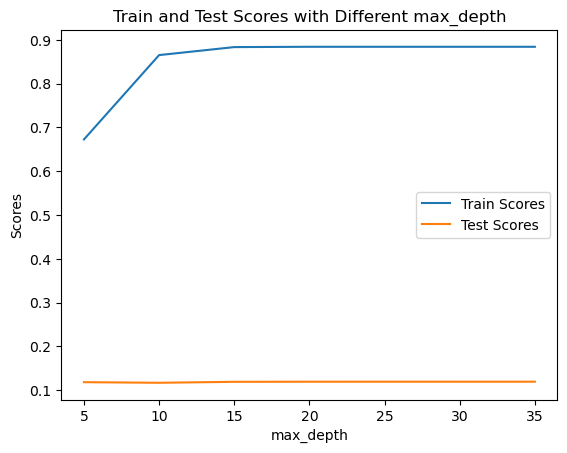

In [90]:
def validate_max_depth(list_of_values):
    test_scores = []
    train_scores = []
    for i in list_of_values:
        train_score, test_score = doRandomForestSetMaxDepth(scaled_df, seed, n_runs, "ice_velocity", ice_velocity, i)
        train_scores.append(train_score)
        test_scores.append(test_score)
    
    print("train scores", train_scores)
    print("test scores", test_scores)
    
    # plot the scores
    plt.plot(list_of_values, train_scores, label='Train Scores')
    plt.plot(list_of_values, test_scores, label='Test Scores')
    
    # add labels and title
    plt.xlabel('max_depth')
    plt.ylabel('Scores')
    plt.title('Train and Test Scores with Different max_depth')
    
    # display the legend
    plt.legend()
    
    # show the plot
    plt.show()

validate_max_depth([5, 10, 15, 20, 25, 30, 35])